In [1]:
import kaolin
import sys
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import polyscope as ps
import interactive_polyscope
from scipy.spatial import Voronoi, voronoi_plot_2d
from io import BytesIO
from PIL import Image
# setting path
sys.path.append('../')
import sdfpred_utils.sdfpred_utils as su
import sdfpred_utils.sdf_MLP as mlp
import sdfpred_utils.sdf_functions as sdf
import sdfpred_utils.loss_functions as lf
import trimesh
from scipy.spatial import Delaunay, Voronoi


#cuda devices
device = torch.device("cuda:0")
print("Using device: ", torch.cuda.get_device_name(device))

#default tensor types
torch.set_default_tensor_type(torch.cuda.DoubleTensor)

multires = 2
input_dims = 3
lr_sites = 0.03
lr_model = 0.0003
iterations = 5000
save_every = 100
max_iter = 100
#learning_rate = 0.03
destination = "./images/autograd/3D/"

Using device:  NVIDIA GeForce RTX 3050 Laptop GPU


loaded model


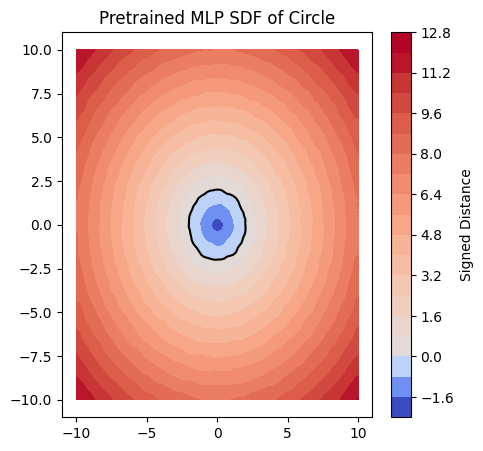

In [3]:
import matplotlib
import os

model = mlp.Decoder(multires=multires, input_dims=2).to(device)
model_path = '../models_resources/pretrained_circle.pth'
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path))
    print('loaded model')
else:
    print("no model found, pretraining")
    model.pre_train_circle(3000, radius=1.0)
    torch.save(model.state_dict(),model_path)

#plot sdf_circle_wave
fig, ax = plt.subplots(figsize=(5, 5))
xx, yy, sdf_values = sdf.plot_sdf(ax, model)

#convert sdf to numpy
sdf_values = sdf_values.cpu().detach().numpy()

norm = matplotlib.colors.TwoSlopeNorm(vmin=np.min(sdf_values), vcenter=0, vmax=np.max(sdf_values))

# Plot the SDF with the centered colormap
contour = plt.contourf(xx, yy, sdf_values, levels=20, cmap="coolwarm", norm=norm)

# Add a colorbar with label
plt.colorbar(contour, label="Signed Distance")
plt.title("Pretrained MLP SDF of Circle")
plt.xlim(-11, 11)
plt.ylim(-11, 11)

plt.show()

torch.Size([128, 2]) torch.float64
Delaunay simplices:  [[121  65   8]
 [  5  58  85]
 [ 32   5  85]
 [ 50  32  85]
 [ 32  50  44]
 [112  32  44]
 [ 32 112   5]
 [ 17  65 121]
 [ 43  29  99]
 [104  47  74]
 [ 57  91  10]
 [ 29  57  99]
 [ 57  29   8]
 [ 91  79  10]
 [ 96  57  10]
 [ 57  96  99]
 [ 94  14  59]
 [ 58  94  85]
 [ 89  94  58]
 [ 94  89  14]
 [  7  59  48]
 [ 43  84 105]
 [ 84  43  99]
 [ 84  87 105]
 [ 82  64  29]
 [ 82  43 105]
 [ 43  82  29]
 [116  75  38]
 [ 75 116   0]
 [ 15 112  44]
 [  0  15  44]
 [116  15   0]
 [ 88  42 125]
 [ 42  88 110]
 [ 59 109  48]
 [ 14 109  59]
 [112  63   5]
 [ 61  12 122]
 [ 20  61 122]
 [101  27  92]
 [ 64 101  92]
 [101  64  33]
 [ 98 101  33]
 [101  98  27]
 [ 27  45  92]
 [103  97  47]
 [ 97  70  47]
 [ 70  62  19]
 [ 70  97  34]
 [ 62  70  34]
 [  4  60 117]
 [ 23  67 125]
 [ 67  23 119]
 [ 97  71  34]
 [ 21  79  91]
 [ 54  21   8]
 [ 21  57   8]
 [ 57  21  91]
 [ 18  96  46]
 [ 87  18  46]
 [ 96  18  99]
 [ 18  84  99]
 [ 84  18  87]

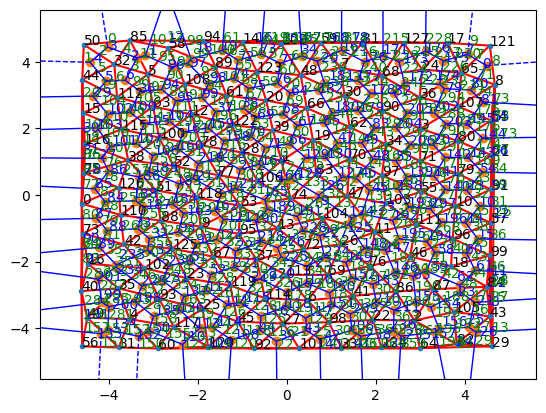

In [14]:

import numpy as np
from scipy.spatial import Delaunay, Voronoi
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
import sdfpred_utils.sdfpred_utils as su



points = np.array([[-1.29121883, 0.04024019],
 [ 3.82579886,  0.01307893],
 [-0.0435634,  -3.37884161],
 [-3.34000104,  3.34717147],
 [-3.80725371, -0.0696819 ],
 [ 0.01656605,  3.39162777],
 [ 1.31297362,  0.0107052 ],
 [ 3.32053027, -3.36299312],
 [ 3.33716388,  3.39748507],
 [-3.35475875, -3.38574726]])

points = np.array(su.createCVTgrid(num_centroids=128).detach().cpu())

voronoi_initial = Voronoi(points[:,:2])

# Compute Delaunay triangulation
delaunay_triangulation = Delaunay(points[:,:2])

#print("Voronoi ridges: ", voronoi_initial.ridge_points)
#print("Voronoi vertices: ", voronoi_initial.vertices)
print("Delaunay simplices: ", delaunay_triangulation.simplices)


fig, ax = plt.subplots()
voronoi_plot_2d(voronoi_initial, ax=ax, show_vertices=True, line_colors='blue')
#plot points index
for i, point in enumerate(points):
    ax.text(point[0], point[1], str(i), color='black')
    #plot points coordinates
    #ax.text(point[0], point[1], f"({point[0]:.2f}, {point[1]:.2f})", color='pink')

#plot the delaunay simplices with index
for i, simplex in enumerate(delaunay_triangulation.simplices):
    # Compute the circumcenter of the simplex
    circumcenter = np.mean(points[simplex], axis=0)
    ax.text(circumcenter[0], circumcenter[1], str(i), color='blue')

# plot the ridge points with index
for i, (point1, point2) in enumerate(voronoi_initial.ridge_points):
    # Compute the midpoint of the ridge
    midpoint = (points[point1] + points[point2]) / 2
    ax.text(midpoint[0], midpoint[1], str(i), color='green')

# # Plot the points
# plt.scatter(points[:, 0], points[:, 1], color='blue')
# #change color of point 0
# plt.scatter(points[0, 0], points[0, 1], color='red')
# Plot the Delaunay triangulation
ax.triplot(points[:, 0], points[:, 1], delaunay_triangulation.simplices, color='red')
# plt.xlim(-6, 6)
# plt.ylim(-6, 6)
plt.show()

In [15]:
ridges = voronoi_initial.ridge_points
vertices = voronoi_initial.vertices
simplices = delaunay_triangulation.simplices

sdf_values = model(torch.tensor(points, device=device))  # Assuming model outputs (N, 1) or (N,) tensor

#todo fix this as its the good way to do it
neighbors = torch.tensor(np.array(ridges), device=device)
all_tetrahedra = torch.tensor(np.array(simplices), device=device)

# Extract the SDF values for each site in the pair
sdf_i = sdf_values[neighbors[:, 0]]  # First site in each pair
sdf_j = sdf_values[neighbors[:, 1]]  # Second site in each pair
# Find the indices where SDF values have opposing signs or one is zero
mask = (sdf_i * sdf_j <= 0).squeeze()
zero_crossing_pairs = neighbors[mask]

print("zero_crossing_pairs_TORCH", zero_crossing_pairs)


zero_crossing_pairs_TORCH tensor([[ 39,  66],
        [ 39,  20],
        [ 39, 122],
        [ 47, 103],
        [ 47,  97],
        [ 47,  11],
        [ 70,  97],
        [ 70,  62],
        [ 70,  34],
        [ 19,  62],
        [ 19,  66],
        [ 76,  26],
        [122,  28],
        [  9,  95],
        [  9,  53],
        [  9, 118],
        [ 51, 118],
        [ 88, 118],
        [ 11, 104],
        [ 11,  26],
        [ 77,  78],
        [ 77,  52],
        [ 28,  78],
        [118,  52],
        [ 95,  67],
        [ 95,  37],
        [ 72, 113],
        [ 72,  69],
        [ 72,  37],
        [ 69,  26],
        [ 37,  13]], dtype=torch.int32)


In [16]:
zero_crossing_vertices_index = []
#convert tensor to np array
zero_crossing_pairs_list = zero_crossing_pairs.cpu().detach().numpy()

for triplet in simplices:
    triplet_pairs = {(triplet[0], triplet[1]), (triplet[1], triplet[2]), (triplet[0], triplet[2])}
    if any(pair in zero_crossing_pairs_list for pair in triplet_pairs):
        zero_crossing_vertices_index.append(triplet)
#####################
# vectorized version
simplices_tensor = torch.tensor(simplices, device = device)  # Shape: (M, 3)
sdf_i = sdf_values[simplices_tensor[:, 0]]  # First site in each pair
sdf_j = sdf_values[simplices_tensor[:, 1]]  # Second site in each pair
sdf_k = sdf_values[simplices_tensor[:, 2]]  # Third site in each pair
# Find the indices where SDF values have opposing signs or one is zero
mask = (sdf_i * sdf_j <= 0).squeeze() | (sdf_i * sdf_k <= 0).squeeze() | (sdf_j * sdf_k <= 0).squeeze()
print("mask", mask)
zero_crossing_vertices_index_vectorized = simplices_tensor[mask]
#######################

computed_v = su.compute_all_vertices(torch.tensor(points, device=device), zero_crossing_vertices_index)
vectorized_v = su.compute_all_vertices(torch.tensor(points, device=device),zero_crossing_vertices_index_vectorized)
#compare both arrays to see if they are the same
# must trim to 3 decimals to compare
#vertices = np.around(vertices, 3)
computed_v = computed_v.detach().cpu().numpy()
computed_v = np.around(computed_v, 3)
vectorized_v = vectorized_v.detach().cpu().numpy()
vectorized_v = np.around(vectorized_v, 3)

print("Computed vertices length: ", len(computed_v))
print("Vectorized vertices length: ", len(vectorized_v))
print("Vectorized_V and Computed_V: ", np.array_equal(vectorized_v, computed_v))

mask tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False,  True,  True,  True,  True,  True,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False,  True, False,  True,  True,  True,
         True, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False,  True,  True,  True,  True,  True, False, Fa

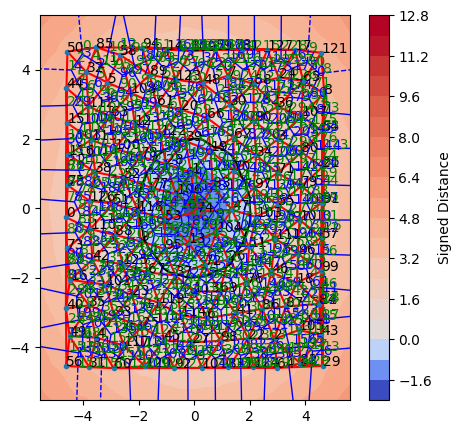

In [ ]:
#plot sdf_circle_wave
fig, ax = plt.subplots(figsize=(5, 5))
xx, yy, sdf_values = sdf.plot_sdf(ax, model)

#convert sdf to numpy
sdf_values = sdf_values.cpu().detach().numpy()

norm = matplotlib.colors.TwoSlopeNorm(vmin=np.min(sdf_values), vcenter=0, vmax=np.max(sdf_values))

# Plot the SDF with the centered colormap
contour = plt.contourf(xx, yy, sdf_values, levels=20, cmap="coolwarm", norm=norm)

# Add a colorbar with label
plt.colorbar(contour, label="Signed Distance")

voronoi_plot_2d(voronoi_initial, ax=ax, show_vertices=False, line_colors='blue')
#plot points index
for i, point in enumerate(points):
    #ax.text(point[0], point[1], str(i), color='black')
    #plot points coordinates
    #ax.text(point[0], point[1], f"({point[0]:.2f}, {point[1]:.2f})", color='pink')
    continue

#plot the delaunay simplices with index
for i, simplex in enumerate(delaunay_triangulation.simplices):
    #Compute the circumcenter of the simplex
    circumcenter = np.mean(points[simplex], axis=0)
    #ax.text(circumcenter[0], circumcenter[1], str(i), color='blue')

#plot the ridge points with index
for i, (point1, point2) in enumerate(voronoi_initial.ridge_points):
    #Compute the midpoint of the ridge
    midpoint = (points[point1] + points[point2]) / 2
    #ax.text(midpoint[0], midpoint[1], str(i), color='green')


#Plot the Delaunay triangulation
#ax.triplot(points[:, 0], points[:, 1], delaunay_triangulation.simplices, color='red')

#scatter vectorized_v
plt.scatter(vectorized_v[:, 0], vectorized_v[:, 1], color='green')
# scatter computed
#plt.scatter(computed_v[:, 0], computed_v[:, 1], color='yellow')

plt.show()